# Slice & preprocess the REU data (3D vars include) for ML tasks
**Authors: Yu Huang, Sungduk Yu, Julius Busecke**

Approximate run time for this notebook:

* 10min (32G mem & 4CPU) for calculating daily mean of one 2D variable and one 3D variable from the original 10-yr 20-min time step data

GitHub repository links: [tutorials for REU dataset](https://github.com/sungdukyu/LEAP_REU_Dataset_Notebook); [LEAP-REU23 Bootcamp](https://github.com/leap-stc/LEAP-bootcamps).


### Install and load python packages

We use [mamba](https://mamba.readthedocs.io/en/latest/installation.html) (instead of conda) to install packages on Hub. Please click the "+" button on the leftup corner to launch a terminal, copy the below commands after "!" and run them on the terminal if you cannot directly import them

In [1]:
# ! mamba install -y pynco pynio pyngl

In [2]:
import gcsfs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cftime

### Load dataset from Google Cloud

#### Open Google Cloud Storage File System


In [3]:
fs = gcsfs.GCSFileSystem()

#### List files in the bucket where the E3SM-MMF dataset is stored


In [4]:
fs.ls("gs://leap-persistent-ro/sungdukyu")

['leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr',
 'leap-persistent-ro/sungdukyu/testing']

#### Open the file you want using xarray


In [5]:
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
ds = xr.open_dataset(mapper, engine='zarr',chunks={'sample': 720}) # ,chunks={'sample': 720}

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/dataset.py:255: UserWarning: The specified Dask chunks separate the stored chunks along dimension "sample" starting at index 720. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


#### Check which variables are included & their dimensions/shapes 

Use [E3SM-MMF Dataset Variable List](https://docs.google.com/spreadsheets/d/1ljRfHq6QB36u0TuoxQXcV4_DSQUR0X4UimZ4QHR8f9M/edit#gid=0) to check the physical meaning of each variable.

Check the original data coordinates first. Instead of using time, latitude, longitude as the coordinates, the raw data uses **sample**(time step) and **ncol**(column index).


In [6]:
ds

<xarray.Dataset>
Dimensions:         (sample: 210240, ncol: 384, lev: 60)
Dimensions without coordinates: sample, ncol, lev
Data variables: (12/16)
    cam_out_FLWDS   (sample, ncol) float64 dask.array<chunksize=(720, 384), meta=np.ndarray>
    cam_out_NETSW   (sample, ncol) float64 dask.array<chunksize=(720, 384), meta=np.ndarray>
    cam_out_PRECC   (sample, ncol) float64 dask.array<chunksize=(720, 384), meta=np.ndarray>
    cam_out_PRECSC  (sample, ncol) float64 dask.array<chunksize=(720, 384), meta=np.ndarray>
    cam_out_SOLL    (sample, ncol) float64 dask.array<chunksize=(720, 384), meta=np.ndarray>
    cam_out_SOLLD   (sample, ncol) float64 dask.array<chunksize=(720, 384), meta=np.ndarray>
    ...              ...
    state_q0003     (sample, lev, ncol) float64 dask.array<chunksize=(720, 60, 384), meta=np.ndarray>
    state_t         (sample, lev, ncol) float64 dask.array<chunksize=(720, 60, 384), meta=np.ndarray>
    state_u         (sample, lev, ncol) float64 dask.array<chunksize=(720, 60, 384), meta=np.ndarray>
    state_v         (sample, lev, ncol) float64 dask.array<chunksize=(720, 60, 384), meta=np.ndarray>
    tod             (sample) int32 dask.array<chunksize=(720,), meta=np.ndarray>
    ymd             (sample) int32 dask.array<chunksize=(720,), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

### Reorganize the temporal dimension/coordinate

#### Add the *time* dimension  
Originally the time information is coded in the variables **ymd** and **tod**. The **sample** index represents the time step count. 

**ymd** includes date information: the first digit indicates the index of year, the next two digits indicate the month and the last three digits indicates the calendar day in the year.

**tod** represents time in the day counted in seconds.

In [7]:
# a more efficient way 

def ymd_tod_to_date(ymd:int, tod:int) -> dict:
    year=ymd//10000
    month=ymd%10000//100
    day=ymd%10000%100
    hour=tod//3600
    minute=tod%3600//60
    return dict(year=year, month=month, day=day, hour=hour, minute=minute)

start_date_dict = ymd_tod_to_date(ds['ymd'][0].data, ds['tod'][0].data)
start_date = cftime.DatetimeNoLeap(start_date_dict['year'], start_date_dict['month'], start_date_dict['day'], start_date_dict['hour'], start_date_dict['minute'])
time = xr.cftime_range(start=start_date, freq='1200S', periods=len(ds.ymd))
ds = ds.assign(sample=time).rename({'sample':'time'}).drop(['tod', 'ymd'])

# Check the current **time** dimension, read the timestep
ds.time.values[0:5]

array([cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 0, 20, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 0, 40, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 1, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 1, 20, 0, 0, has_year_zero=True)],
      dtype=object)

In [8]:
ds

<xarray.Dataset>
Dimensions:         (time: 210240, ncol: 384, lev: 60)
Coordinates:
  * time            (time) object 0001-02-01 00:00:00 ... 0009-01-31 23:40:00
Dimensions without coordinates: ncol, lev
Data variables: (12/14)
    cam_out_FLWDS   (time, ncol) float64 dask.array<chunksize=(720, 384), meta=np.ndarray>
    cam_out_NETSW   (time, ncol) float64 dask.array<chunksize=(720, 384), meta=np.ndarray>
    cam_out_PRECC   (time, ncol) float64 dask.array<chunksize=(720, 384), meta=np.ndarray>
    cam_out_PRECSC  (time, ncol) float64 dask.array<chunksize=(720, 384), meta=np.ndarray>
    cam_out_SOLL    (time, ncol) float64 dask.array<chunksize=(720, 384), meta=np.ndarray>
    cam_out_SOLLD   (time, ncol) float64 dask.array<chunksize=(720, 384), meta=np.ndarray>
    ...              ...
    state_q0001     (time, lev, ncol) float64 dask.array<chunksize=(720, 60, 384), meta=np.ndarray>
    state_q0002     (time, lev, ncol) float64 dask.array<chunksize=(720, 60, 384), meta=np.ndarray>
    state_q0003     (time, lev, ncol) float64 dask.array<chunksize=(720, 60, 384), meta=np.ndarray>
    state_t         (time, lev, ncol) float64 dask.array<chunksize=(720, 60, 384), meta=np.ndarray>
    state_u         (time, lev, ncol) float64 dask.array<chunksize=(720, 60, 384), meta=np.ndarray>
    state_v         (time, lev, ncol) float64 dask.array<chunksize=(720, 60, 384), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

#### Reduce the data size/coarse the time resolution 

The **time** dimension is large. For avoid memory issues, currently we'll keep only one sample each day. 

You can take the daily/monthly mean/max/min data or the data at a specific time each day. 

There are many ways to do that. You can uncomment the codes to try.

#### Our goal: get daily mean of precip and specific humidity

When reading in the data as chunks, [dask package](https://examples.dask.org/xarray.html) is implicitly used.


In [9]:
# keep a copy of the original data at 20-min time step and gridded by column index
ds_origin = ds.copy()

# when reading in the data as chunks, dask package is used and the .mean() below does not lead to instantaneous math calculation
# 1. use coarsen function
ds = ds.coarsen(time = 72).mean()

# 2. tried to resample the whole dataset but then the memory blows up
# ds = ds.resample(time='1D').mean('time')
# ds

# 3. select data at noon per day for the whole dataset - way more faster and no need to use chunks or dask 
# itime = np.arange(36,len(ds.time),24*3)
# ds = ds.isel(time = itime)
# ds

In [10]:
# do the transformation so we have: total precipitation = snow + rainfall

ds['cam_out_PRECT'] = ds['cam_out_PRECC'] + ds['cam_out_PRECSC']
# ds = ds[['cam_out_PRECT', 'cam_out_NETSW']].resample(time='1M').mean(dim='time')
ds

<xarray.Dataset>
Dimensions:         (time: 2920, ncol: 384, lev: 60)
Coordinates:
  * time            (time) object 0001-02-01 11:50:00 ... 0009-01-31 11:50:00
Dimensions without coordinates: ncol, lev
Data variables: (12/15)
    cam_out_FLWDS   (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    cam_out_NETSW   (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    cam_out_PRECC   (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    cam_out_PRECSC  (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    cam_out_SOLL    (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    cam_out_SOLLD   (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
    ...              ...
    state_q0002     (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 384), meta=np.ndarray>
    state_q0003     (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 384), meta=np.ndarray>
    state_t         (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 384), meta=np.ndarray>
    state_u         (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 384), meta=np.ndarray>
    state_v         (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 384), meta=np.ndarray>
    cam_out_PRECT   (time, ncol) float64 dask.array<chunksize=(10, 384), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

### Convert the dimension/coordinate of column index to structured lat, lon 

#### Open a file that stores grid information, and check the original lat, lon information

In [11]:
# grid info
mapper = fs.get_mapper("gs://leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
ds_grid = xr.open_dataset(mapper, engine='zarr')
ds_grid

<xarray.Dataset>
Dimensions:  (ncol: 384, ilev: 61, lev: 60)
Dimensions without coordinates: ncol, ilev, lev
Data variables:
    P0       float64 ...
    area     (ncol) float64 ...
    hyai     (ilev) float64 ...
    hyam     (lev) float64 ...
    hybi     (ilev) float64 ...
    hybm     (lev) float64 ...
    lat      (ncol) float64 ...
    lon      (ncol) float64 ...
Attributes: (12/19)
    Conventions:       CF-1.7
    case:              E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2
    contact:           e3sm-data-support@listserv.llnl.gov
    fv_nphys:          2
    git_version:       4108bd8c11
    history:           created on 01/13/23 15:30:04
    ...                ...
    source:            E3SM Atmosphere Model
    source_id:         4108bd8c11
    time_period_freq:  month_1
    title:             EAM History file information
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    username:          sungduk

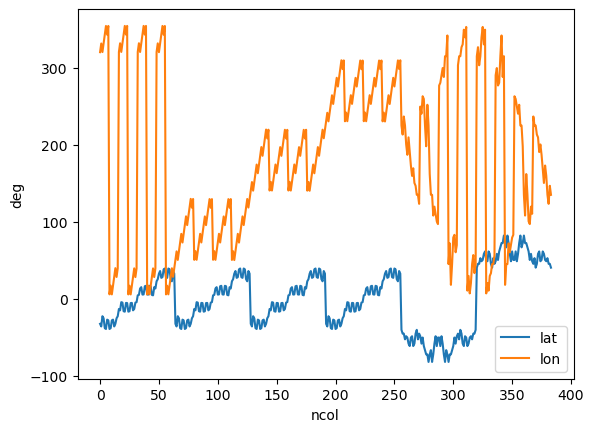

In [12]:
fig, ax = plt.subplots()
ds_grid['lat'].plot(label='lat', ax=ax)
ds_grid['lon'].plot(label='lon', ax=ax)
ax.set_ylabel('deg')
ax.legend()

In [13]:
print('column number is ',len(np.unique(ds_grid.ncol.values)))
print('if each lat occured in the data can be paired with a lon, the (lat,lon) grid number is', len(np.unique(ds_grid.lat.values))*len(np.unique(ds_grid.lon.values)))
np.unique(ds_grid.lon.values.round(2))

column number is  384
if each lat occured in the data can be paired with a lon, the (lat,lon) grid number is 17313


array([  5.63,   5.65,   5.68,   5.73,   6.97,  10.54,  16.89,  16.91,
        16.96,  17.02,  18.06,  20.4 ,  28.15,  28.2 ,  28.31,  28.47,
        29.62,  33.28,  39.4 ,  39.46,  39.56,  39.73,  45.  ,  50.27,
        50.44,  50.54,  50.6 ,  56.72,  60.38,  61.53,  61.69,  61.8 ,
        61.85,  69.6 ,  71.94,  72.98,  73.04,  73.09,  73.11,  79.46,
        83.03,  84.27,  84.32,  84.35,  84.37,  95.63,  95.65,  95.68,
        95.73,  96.97, 100.54, 106.89, 106.91, 106.96, 107.02, 108.06,
       110.4 , 118.15, 118.2 , 118.31, 118.47, 119.62, 123.28, 129.4 ,
       129.46, 129.56, 129.73, 135.  , 140.27, 140.44, 140.54, 140.6 ,
       146.72, 150.38, 151.53, 151.69, 151.8 , 151.85, 159.6 , 161.94,
       162.98, 163.04, 163.09, 163.11, 169.46, 173.03, 174.27, 174.32,
       174.35, 174.37, 185.63, 185.65, 185.68, 185.73, 186.97, 190.54,
       196.89, 196.91, 196.96, 197.02, 198.06, 200.4 , 208.15, 208.2 ,
       208.31, 208.47, 209.62, 213.28, 219.4 , 219.46, 219.56, 219.73,
      

#### Change the geo-coordinate from column index to multi-index (lat, lon) 

In [14]:
# original lat and lon info
lat = ds_grid.lat.values.round(2) 
lon = ds_grid.lon.values.round(2) 

# merge the original grid info with the dataset containing atmos variables
ds_multiindex = ds.copy()
ds_multiindex['lat'] = (('ncol'),lat.T) # (('sample', 'ncol'),lat.T)
ds_multiindex['lon'] = (('ncol'),lon.T)

# use multi-index and unstack function to convert the 1D dimension/coordinate ncol to 2D lat and lon
ds_multiindex['index_id'] = ds_multiindex.coords['ncol'].copy()
ds_multiindex.coords['ncol'] = pd.MultiIndex.from_arrays([lat, lon], names=['lat', 'lon'])
ds_multiindex = ds_multiindex.unstack('ncol')

#### Select the domain and unstack variables as wanted

In [15]:
# slice the data as wanted, only keep the variables and domain that you're interested in
# here I only keep the data within \pm 45 degree in lat
ds_sel = ds_multiindex[['state_q0001','cam_out_PRECC', 'index_id']].sel(lat = slice(-45,45))
ds_sel

<xarray.Dataset>
Dimensions:        (time: 2920, lev: 60, lat: 34, lon: 180)
Coordinates:
  * lat            (lat) float64 -40.39 -39.26 -38.2 -35.99 ... 38.2 39.26 40.39
  * lon            (lon) float64 5.63 5.65 5.68 5.73 ... 354.3 354.3 354.4 354.4
  * time           (time) object 0001-02-01 11:50:00 ... 0009-01-31 11:50:00
Dimensions without coordinates: lev
Data variables:
    state_q0001    (time, lev, lat, lon) float64 dask.array<chunksize=(10, 60, 34, 180), meta=np.ndarray>
    cam_out_PRECC  (time, lat, lon) float64 dask.array<chunksize=(10, 34, 180), meta=np.ndarray>
    index_id       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

For ML purpose, we treat each column on each day as one sample entry, so it's better NOT to convert the dimension to lat and lon for ML tasks, because it will increase the dimension size and lead to many NaNs.

Instead, we want to select data based on lat and lon information, but use original column index as the data dimension.

In [16]:
# get the column index from the above dataset
iid = ds_sel.index_id.values
iid = iid[~np.isnan(iid)].astype(int)
print(iid)
ds_sel2 = ds.sel(ncol = iid)
ds_sel2

[319 269 256 306   8  69  72 133 136 197 200   5   9  68  73 132 137 196
 201   4  12  65  76 129 140 193 204   1  13  64  77 128 141 192 205   0
  10  71  74 135 138 199 202   7  11  70  75 134 139 198 203   6  14  67
  78 131 142 195 206   3  15  66  79 130 143 194 207   2  24  85  88 149
 152 213 216  21  25  84  89 148 153 212 217  20  28  81  92 145 156 209
 220  17  29  80  93 144 157 208 221  16  26  87  90 151 154 215 218  23
  27  86  91 150 155 214 219  22  30  83  94 147 158 211 222  19  31  82
  95 146 159 210 223  18  45  96 109 160 173 224 237  32  44  97 108 161
 172 225 236  33  41 100 105 164 169 228 233  36  40 101 104 165 168 229
 232  37  47  98 111 162 175 226 239  34  46  99 110 163 174 227 238  35
  43 102 107 166 171 230 235  38  42 103 106 167 170 231 234  39  61 112
 125 176 189 240 253  48  60 113 124 177 188 241 252  49  57 116 121 180
 185 244 249  52  56 117 120 181 184 245 248  53  63 114 127 178 191 242
 255  50  62 115 126 179 190 243 254  51  59 118 12

<xarray.Dataset>
Dimensions:         (time: 2920, ncol: 264, lev: 60)
Coordinates:
  * time            (time) object 0001-02-01 11:50:00 ... 0009-01-31 11:50:00
Dimensions without coordinates: ncol, lev
Data variables: (12/15)
    cam_out_FLWDS   (time, ncol) float64 dask.array<chunksize=(10, 264), meta=np.ndarray>
    cam_out_NETSW   (time, ncol) float64 dask.array<chunksize=(10, 264), meta=np.ndarray>
    cam_out_PRECC   (time, ncol) float64 dask.array<chunksize=(10, 264), meta=np.ndarray>
    cam_out_PRECSC  (time, ncol) float64 dask.array<chunksize=(10, 264), meta=np.ndarray>
    cam_out_SOLL    (time, ncol) float64 dask.array<chunksize=(10, 264), meta=np.ndarray>
    cam_out_SOLLD   (time, ncol) float64 dask.array<chunksize=(10, 264), meta=np.ndarray>
    ...              ...
    state_q0002     (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 264), meta=np.ndarray>
    state_q0003     (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 264), meta=np.ndarray>
    state_t         (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 264), meta=np.ndarray>
    state_u         (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 264), meta=np.ndarray>
    state_v         (time, lev, ncol) float64 dask.array<chunksize=(10, 60, 264), meta=np.ndarray>
    cam_out_PRECT   (time, ncol) float64 dask.array<chunksize=(10, 264), meta=np.ndarray>
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [17]:
from dask.diagnostics import ProgressBar

# visualize with progress bar
# use .load() or .compute() to do the math and get the daily mean data

with ProgressBar():
    # if use lat and lon as the dimensions
    # ds_processed = ds_sel[['state_q0001','cam_out_PRECC']].load()
    # if use ncol as the dimensions
    ds_processed = ds_sel2[['state_q0001','cam_out_PRECC']].load()

[########################################] | 100% Completed | 271.60 s


In [37]:
# convert xr dataset to numpy array for next ML tasks
stateq_ml = ds_processed['state_q0001'].values
prec_ml = ds_processed['cam_out_PRECC'].values
print('time, lev, ncol:', np.shape(stateq_ml))
print('time, lev, ncol:', np.shape(prec_ml))


time, lev, ncol: (2920, 60, 264)
time, lev, ncol: (2920, 264)


In [38]:
# release some memory storing the variables that are not gonna be used later
# del ds, ds_origin

### Stack different variables together

Treat each column on each day as an indepedent sample and now either use numpy to process stateq_ml and prec_ml.

OR follow Sungduk's [tutorial](https://github.com/sungdukyu/LEAP_REU_Dataset_Notebook/blob/main/ML_notebook/ML_notebook_part2_training.ipynb) to stack the data together using xarray. Use the method that you're more familiar with.


In [39]:
# for 2d variables it is simple to reshape 
prec_ml = prec_ml.reshape(-1)
np.shape(prec_ml)

(770880,)

(2920, 264)


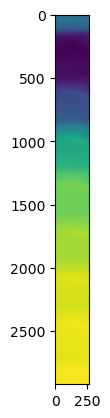

In [40]:
plt.imshow(stateq_ml[:,1,:])
print(np.shape(stateq_ml[:,1,:]))

In [41]:
# need to use np.transpose to rearrange dimensions for 3d vars 
# then apply np.reshape to make sure that you're not reshaping the data for the wrong dimensions
stateq_ml = stateq_ml.transpose(1,0,2)
np.shape(stateq_ml)

(60, 2920, 264)

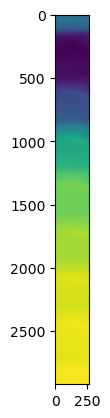

In [42]:
# double check that we're doing the right thing 

plt.imshow(stateq_ml[1,:,:])

In [22]:
stateq_ml = stateq_ml.reshape(60,-1)
np.shape(stateq_ml)

(60, 770880)

In [23]:
# stack/pack all variables (here two vars) into one long array for each sample
array_ml = np.vstack((stateq_ml, prec_ml))
np.shape(array_ml)

(61, 770880)

Now it's ready to go for training (**data is not normalized though**). You can do normalization before converting xr.dataset to np.array~